# Transformer
* document transformer test

features
* merge text nodes

In [1]:
import json
from pathlib import Path
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../.env", env_file_encoding="utf-8", extra="ignore"
    )
    data_dir: str
    docling_model_dir: str
    
settings = Settings()
os.environ["HF_HOME"] = settings.docling_model_dir

# Load Reader & Document

In [2]:
import sys
sys.path.append("src")

from core.base.schema import TextNode, ImageNode, TableNode, TextType, TextLabel
from core.reader.docling.pdf_reader import DoclingPDFReader

In [3]:
reader = DoclingPDFReader()

In [4]:
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

# file_path = os.path.join(pdf_dir, pdf_fnames[0])
file_path = "resources/finance-small-images.pdf"
file_path = "resources/1706.03762v7.pdf"
# file_path = "resources/1706.03762v7-sample.pdf"
# file_path = "resources/list_group_sample_msword.pdf"
# file_path = "resources/list_group_sample_google.pdf"
document = reader.run(file_path)

num files: 10


In [5]:
nodes = document.nodes
print(len(nodes))

136


avg 230.016 min 1 max 1138


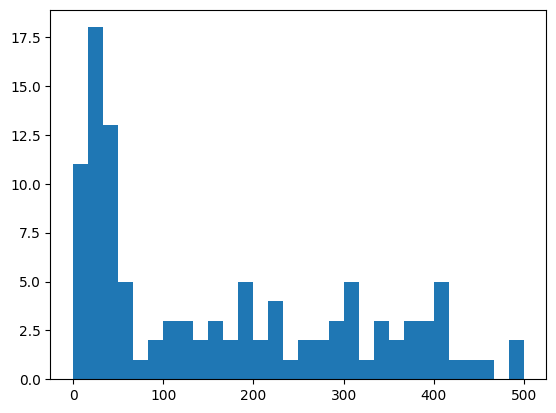

In [6]:
## Check Text Len
text_lens = [len(node.text) for node in nodes if isinstance(node, TextNode)]

print("avg {:.3f} min {} max {}".format(np.mean(text_lens), np.min(text_lens), np.max(text_lens)))
plt.hist(text_lens, bins=30, range=(0, 500))
plt.show()


In [7]:
def _create_text_node(text: str) -> TextNode:
    return TextNode(
        text=text,
        label=TextLabel.PLAIN,
        metadata={}
    )


merged_nodes = []

_merge_window = []
stop_threshold = 5000
for node in nodes:
    if not isinstance(node, TextNode):
        # stop merging
        if _merge_window:
            merged_node = _create_text_node("\n".join(_merge_window))
            merged_nodes.append(merged_node)
            _merge_window = []
            
        merged_nodes.append(node)
    else:
        text = node.text
        _merge_window.append(text)
        
        if len("\n".join(_merge_window)) > stop_threshold:
            merged_node = _create_text_node("\n".join(_merge_window))
            merged_nodes.append(merged_node)
            _merge_window = []
            
print(len(merged_nodes))

26


In [8]:
merged_nodes[:10]

[TextNode(id_='9afcb3bc-0df2-4d4e-91bb-8e709f92e6df', metadata={}, text_type=<TextType.PLAIN: 'plain'>, label=<TextLabel.PLAIN: 'plain'>, resource=MediaResource(data=None, text='arXiv:1706.03762v7  [cs.CL]  2 Aug 2023\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\nAttention Is All You Need\nAshish Vaswani ∗ Google Brain avaswani@google.com\nNoam Shazeer ∗ Google Brain noam@google.com\nNiki Parmar ∗ Google Research nikip@google.com\nJakob Uszkoreit ∗ Google Research usz@google.com\nLlion Jones ∗ Google Research llion@google.com\nAidan N. Gomez ∗ † University of Toronto aidan@cs.toronto.edu\nŁukasz Kaiser Google Brain lukaszkaiser@google.com\n∗\nIllia Polosukhin ∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best perfo

In [9]:
## Check Text Len
text_lens = [len(node.text) for node in merged_nodes if isinstance(node, TextNode)]

print("avg {:.3f} min {} max {}".format(np.mean(text_lens), np.min(text_lens), np.max(text_lens)))
# plt.hist(text_lens, bins=10, range=(0, 500))
# plt.show()


avg 2045.143 min 133 max 5377


# Module

In [10]:
from core.processor.document.text_merger import TextNodeMerger

merger = TextNodeMerger()
merged_document = merger.run(document)
len(merged_document.nodes)

26